<a href="https://colab.research.google.com/github/jwkanggist/EverybodyTensorflow2.0/blob/master/lab3_curvefitting_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB3 Curve-fitting
목적: 가장 기본적인 머신러닝 연습문제인 curve fitting 문제를 tf2.0을 가지고 풀어보자!

In [0]:
# preprocessor parts

from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

import numpy as np

from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt

from datetime import datetime

In [3]:
  # for Tensorboard use
  LOG_DIR = 'drive/data/tb_logs'
	
  !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
  !unzip ngrok-stable-linux-amd64.zip
	
  import os
  if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)
	  
  get_ipython().system_raw(
      'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
      .format(LOG_DIR))
	
  get_ipython().system_raw('./ngrok http 6006 &')
	
  !curl -s http://localhost:4040/api/tunnels | python3 -c \
      "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-01-03 17:21:39--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.229.196.117, 52.20.119.24, 54.174.175.170, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.229.196.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  14.0MB/s    in 0.9s    

2020-01-03 17:21:46 (14.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://ac24c524.ngrok.io


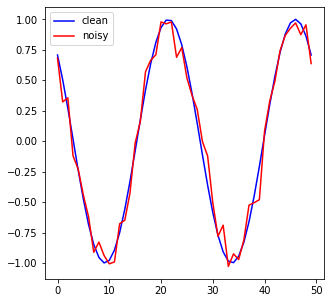

In [4]:
# Data pipeline: generation of data set

total_size = 5000
training_size = 4000
validation_size = total_size - training_size

xsize = 50 # the size of single x_data

x_data = np.zeros([xsize, total_size])
cos_x  = np.zeros([xsize, total_size])

mag     = 1.0
phase_rad = np.pi/4
rad_freq = np.pi / 2.0

for i in range(total_size):
    x_data[:,i] =  np.linspace(-4,4,xsize)
cos_x =  np.cos(rad_freq*x_data + phase_rad)



noise_var   = 0.01
noise       = np.sqrt(noise_var) * np.random.randn(xsize,total_size)
y_clean     = cos_x
y_data      = y_clean + noise

x_train = x_data[:,0:training_size].transpose()
y_train = y_data[:,0:training_size].transpose()

x_test = x_data[:,training_size:-1].transpose()
y_test = y_data[:,training_size:-1].transpose()

# signal plot
hfig1= plt.figure(1,figsize=[5,5])
plt.plot(cos_x[:,1],color='b',label='clean')
plt.plot(y_data[:,1],color='r',label='noisy')
plt.legend()

In [0]:
# model building

net_in = tf.keras.layers.Input(shape=(xsize,))
net = tf.keras.layers.Dense(xsize, activation='linear')(net_in)
net = tf.cos(net)
net = tf.keras.layers.Dense(xsize, activation='linear')(net)

model = tf.keras.models.Model(inputs=net_in,outputs=net)

model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

tensorboard_callback = TensorBoard(log_dir=LOG_DIR, 
                           histogram_freq=1,
                           write_graph=True,
                           write_images=True)

In [6]:
# model training and evaluation part
training_epochs = 20
model.fit(x_train, y_train, 
          epochs=training_epochs,
          validation_data=(x_test, y_test),
          batch_size=128,
          callbacks=[tensorboard_callback])

model.evaluate(x_test,  y_test, verbose=2)

Train on 4000 samples, validate on 999 samples
Epoch 1/20
4000/4000 [==============================] - 1s 269us/sample - loss: 0.1612 - accuracy: 0.1213 - val_loss: 0.0170 - val_accuracy: 0.1832
Epoch 2/20
4000/4000 [==============================] - 0s 34us/sample - loss: 0.0120 - accuracy: 0.2030 - val_loss: 0.0104 - val_accuracy: 0.2202
Epoch 3/20
4000/4000 [==============================] - 0s 33us/sample - loss: 0.0101 - accuracy: 0.1910 - val_loss: 0.0102 - val_accuracy: 0.1872
Epoch 4/20
4000/4000 [==============================] - 0s 31us/sample - loss: 0.0100 - accuracy: 0.1988 - val_loss: 0.0101 - val_accuracy: 0.2202
Epoch 5/20
4000/4000 [==============================] - 0s 27us/sample - loss: 0.0100 - accuracy: 0.1933 - val_loss: 0.0102 - val_accuracy: 0.1832
Epoch 6/20
4000/4000 [==============================] - 0s 29us/sample - loss: 0.0100 - accuracy: 0.1925 - val_loss: 0.0102 - val_accuracy: 0.2202
Epoch 7/20
4000/4000 [==============================] - 0s 30us/sample

[0.010246115956675482, 0.18718718]

In [0]:
# prediction 

plt.figure(1,figsize=(5,5))
test_input = x_test[0,:]
test_output = y_test[0,:]
pred_y = model.predict(test_input.reshape([1,xsize]))
plt.plot(test_input,test_output,label='noisy data',color='b',marker='*')
plt.plot(test_input, pred_y.reshape([xsize,]),label='prediction',color='r')
plt.legend()
plt.title('A line fitting example:')
plt.xlabel('X data')
plt.ylabel('Y data')